# Interpretable ML - COVID19
> Interpretable ML Research for COVID19
- toc:true
- branch: master
- badges: true
- comments: true
- author: Han Wu
- categories: [jupyter]

## 0. Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.set_printoptions(suppress=True)

In [3]:
covid = pd.read_csv("dataset/covid.csv")

In [4]:
print("AVG age for severity 0:", np.mean(covid[covid.Severity03 == 0].Age.to_numpy()))
print("AVG age for severity 1:", np.mean(covid[covid.Severity03 == 1].Age.to_numpy()))
print("AVG age for severity 2:", np.mean(covid[covid.Severity03 == 2].Age.to_numpy()))
print("AVG age for severity 3:", np.mean(covid[covid.Severity03 == 3].Age.to_numpy()))

AVG age for severity 0: 36.833333333333336
AVG age for severity 1: 47.45283018867924
AVG age for severity 2: 54.3125
AVG age for severity 3: 69.4


In [5]:
covid.shape

(92, 74)

## 1. Data Wash

Remove Features that has NULL value

In [6]:
remove_columns = ['MedNum', 'LVEF', 'SO2', 'PO2', 'YHZS', 'RML', 'RUL', 'RLL', 'LUL', 'LLL']

In [7]:
covid = covid.drop(remove_columns, axis=1)

Remove Features that records time rather than biomarkers

In [8]:
remove_columns = ['Onset2Admi', 'Onset2CT1', 'Onset2CTPositive1', 'Onset2CTPeak']

In [9]:
covid = covid.drop(remove_columns, axis=1)

Remove Patients that have no records

In [10]:
covid = covid[covid.Weight != " "]

In [11]:
covid = covid[covid.cTnI != " "]

String to Float

In [12]:
covid['Weight'] = covid['Weight'].astype(np.float64)
covid['Height'] = covid['Height'].astype(np.float64)
covid['cTnITimes'] = covid['cTnITimes'].astype(np.float64)
covid['cTnI'] = covid['cTnI'].astype(np.float64)
covid['NTproBNP'] = covid['NTproBNP'].astype(np.float64)
covid['Cr'] = covid['Cr'].astype(np.float64)

## 2. Train Test Split

### Add New Features

A Sum of symptoms

In [13]:
covid['NSympton'] = covid['Fever'] + covid['Cough'] + covid['Phlegm']\
+ covid['Hemoptysis'] + covid['SoreThroat'] + covid['Catarrh']\
+ covid['Headache'] + covid['ChestPain'] + covid['Fatigue']\
+ covid['SoreMuscle']+covid['Stomachache'] + covid['Diarrhea']\
+ covid['PoorAppetite'] + covid['NauseaNVomit']

A sum of Anamneses

In [14]:
covid['NDisease'] = covid['Hypertention'] + covid['Hyperlipedia'] + covid['DM']\
+ covid['Lung'] + covid['CAD'] + covid['Arrythmia'] + covid['Cancer']

In [15]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [16]:
y = covid.Severity01.to_numpy()

In [17]:
# Use Both
# covid = covid.drop(["Severity01", "Severity03"], axis=1)

In [18]:
# Use AIVolume
# covid = covid.drop(["Severity01", "Severity03", "CTScore"], axis=1)

In [19]:
# Use CTScore
# covid = covid.drop(["Severity01", "Severity03", "AIVolumeP"], axis=1)

In [20]:
# Use None
covid = covid.drop(["Severity01", "Severity03", "CTScore", "AIVolumeP"], axis=1)

Patient No. is irrrelevant

In [21]:
covid = covid.drop(["No"], axis=1)

In [22]:
X = covid
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, random_state = 1)

In [23]:
X_train.shape, X_test.shape

((77, 57), (9, 57))

In [24]:
X_train.columns

Index(['Sex', 'Age', 'AgeG1', 'Height', 'Weight', 'BMI', 'Temp', 'cTnITimes',
       'cTnI', 'cTnICKMBOrdinal1', 'cTnICKMBOrdinal2', 'AST', 'LDH', 'CK',
       'CKMB', 'HBDH', 'HiCKMB', 'NTproBNP', 'Cr', 'PCT1', 'WBC1', 'NEU1',
       'LYM1', 'N2L1', 'CRP1', 'ALB1', 'PCT2', 'WBC2', 'NEU2', 'LYM2', 'N2L2',
       'CRP2', 'ALB2', 'Sympton', 'Fever', 'Cough', 'Phlegm', 'Hemoptysis',
       'SoreThroat', 'Catarrh', 'Headache', 'ChestPain', 'Fatigue',
       'SoreMuscle', 'Stomachache', 'Diarrhea', 'PoorAppetite', 'NauseaNVomit',
       'Hypertention', 'Hyperlipedia', 'DM', 'Lung', 'CAD', 'Arrythmia',
       'Cancer', 'NSympton', 'NDisease'],
      dtype='object')

In [25]:
y_test

array([0, 1, 0, 0, 1, 1, 0, 1, 0], dtype=int64)

## 3. Feature Selection

### 3.1 Basic Methods

#### 3.1.1 Drop constant and Quasi-constant features

In [26]:
from sklearn.feature_selection import VarianceThreshold

In [27]:
def drop_features(X_train, X_test, threshhold):
    sel = VarianceThreshold(threshold=threshhold)
    sel.fit(X_train)
    print("No. of constant features:",
        len([
            x for x in X_train.columns
            if x not in X_train.columns[sel.get_support()]
        ])
    )
    constant_features = [x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]

    print(constant_features)
    X_train.drop(labels=constant_features, axis=1, inplace=True)
    X_test.drop(labels=constant_features, axis=1, inplace=True)

Drop constant and quasi-constant features

In [28]:
drop_features(X_train, X_test, 0.01)

No. of constant features: 2
['PCT2', 'Stomachache']


d:\anaconda3\envs\covid-19\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [29]:
X_train.shape, X_test.shape

((77, 55), (9, 55))

#### 3.1.2 Drop Duplicated Features

Maybe some symptoms are correlated

In [30]:
covid_t = covid.T
print("No. of Duplicated Features:", covid_t.duplicated().sum())
print(covid_t[covid_t.duplicated()].index.values)

No. of Duplicated Features: 1
['Arrythmia']


Print out duplicated features

In [31]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    col_1 = X_train.columns[i]
    for col_2 in X_train.columns[i + 1 : ]:
        if X_train[col_1].equals(X_train[col_2]):
            print(col_1)
            print(col_2)         
            duplicated_feat.append(col_2)

CAD
Arrythmia


Drop duplicated features

In [32]:
# covid_unique = covid_t.drop_duplicates(keep='first').T

In [33]:
X_train.drop(labels=covid_t[covid_t.duplicated()].index.values, axis=1, inplace=True)
X_test.drop(labels=covid_t[covid_t.duplicated()].index.values, axis=1, inplace=True)

In [34]:
X_train.shape, X_test.shape

((77, 54), (9, 54))

### 3.2 Correlations

In [35]:
categorical_features = ['Sex', 'AgeG1', 
                        'Fever', 'Cough', 'Phlegm', 'Hemoptysis', 'SoreThroat', 'Catarrh', 'Headache', 'ChestPain', 'Fatigue', 'SoreMuscle', # 'Stomachache', 
                        'Diarrhea', 'PoorAppetite', 'NauseaNVomit', 
                        'Hypertention', 'Hyperlipedia', 'DM', 'Lung', #'CAD', 'Arrythmia', 
                        'Cancer']

In [36]:
numerical_features = ['Age', 'Height', 'Weight', 'BMI', 'Temp', 'cTnITimes', 'cTnI', 'cTnICKMBOrdinal1', 'cTnICKMBOrdinal2', 'AST',
       'LDH', 'CK', 'CKMB', 'HBDH', 'HiCKMB', 'NTproBNP', 'Cr', 'PCT1', 'WBC1',
       'NEU1', 'LYM1', 'N2L1', 'CRP1', 'ALB1', 'WBC2', 'NEU2', 'LYM2', 'N2L2',
       'CRP2', 'ALB2']

In [37]:
# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# numerical_vars = list(covid.select_dtypes(include=numerics).columns)
# data = covid[numerical_vars]

In [38]:
corrmat = X_train.corr()

<AxesSubplot:>

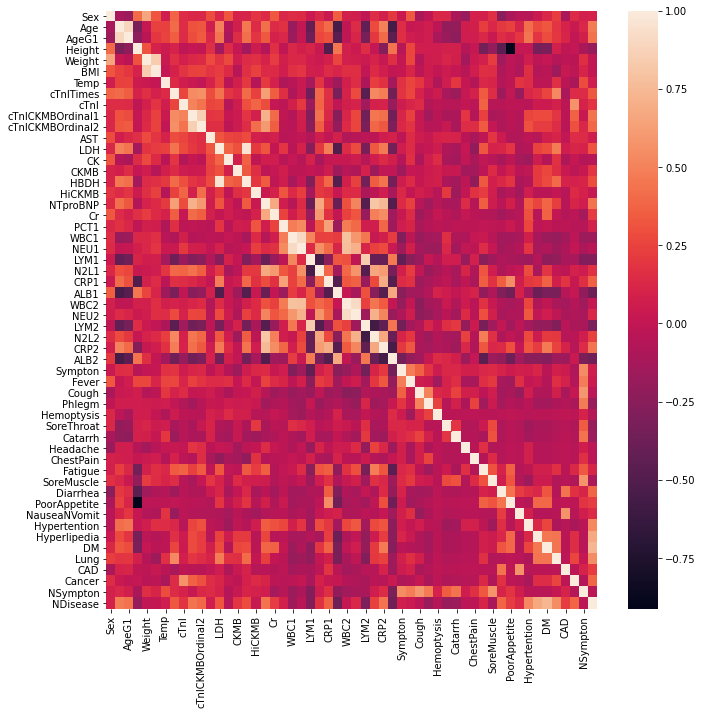

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 11)
sns.heatmap(corrmat)

In [40]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack()
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat

,feature1,feature2,corr
0,LDH,HBDH,0.958191
1,HBDH,LDH,0.958191
2,Height,PoorAppetite,0.911704
3,PoorAppetite,Height,0.911704
4,WBC2,NEU2,0.911419
5,NEU2,WBC2,0.911419
6,NEU1,WBC1,0.903520
7,WBC1,NEU1,0.903520
8,Age,AgeG1,0.893413
9,AgeG1,Age,0.893413


In [41]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))

found 9 correlated groups
out of 54 total features


In [42]:
# now we can visualise each group. We see that some groups contain
# only 2 correlated features, some other groups present several features 
# that are correlated among themselves.

for group in correlated_groups:
    print(group)
    print()

  feature1 feature2      corr
0      LDH     HBDH  0.958191

  feature1      feature2      corr
2   Height  PoorAppetite  0.911704

  feature1 feature2      corr
4     WBC2     NEU2  0.911419

  feature1 feature2     corr
6     NEU1     WBC1  0.90352

  feature1 feature2      corr
8      Age    AgeG1  0.893413

            feature1          feature2      corr
10  cTnICKMBOrdinal1  cTnICKMBOrdinal2  0.853741

   feature1 feature2      corr
12     LYM2     LYM1  0.842688

   feature1 feature2      corr
14      BMI   Weight  0.842409

   feature1  feature2      corr
16     N2L2  NTproBNP  0.808767



In [43]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j] >= threshold):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [44]:
corr_features = list((correlation(X_train, 0.8)))
print(corr_features)

['cTnICKMBOrdinal2', 'LYM2', 'AgeG1', 'HBDH', 'BMI', 'NEU1', 'NEU2', 'N2L2']


In [45]:
for i in corr_features:
    if i in categorical_features:
        corr_features.remove(i)

In [46]:
for i in corr_features:
    if i in numerical_features:
        numerical_features.remove(i)

for i in corr_features:
    if i in categorical_features:
        categorical_features.remove(i)

In [47]:
corr_features

['cTnICKMBOrdinal2', 'LYM2', 'HBDH', 'BMI', 'NEU1', 'NEU2', 'N2L2']

In [48]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

d:\anaconda3\envs\covid-19\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [49]:
X_train.shape, X_test.shape

((77, 47), (9, 47))

### 3.3 Statistical Methods

#### 3.3.1 Mutual Information

In [50]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [51]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi)
mi.index = X_train.columns

Features on the left side have more mutual information with y

<AxesSubplot:>

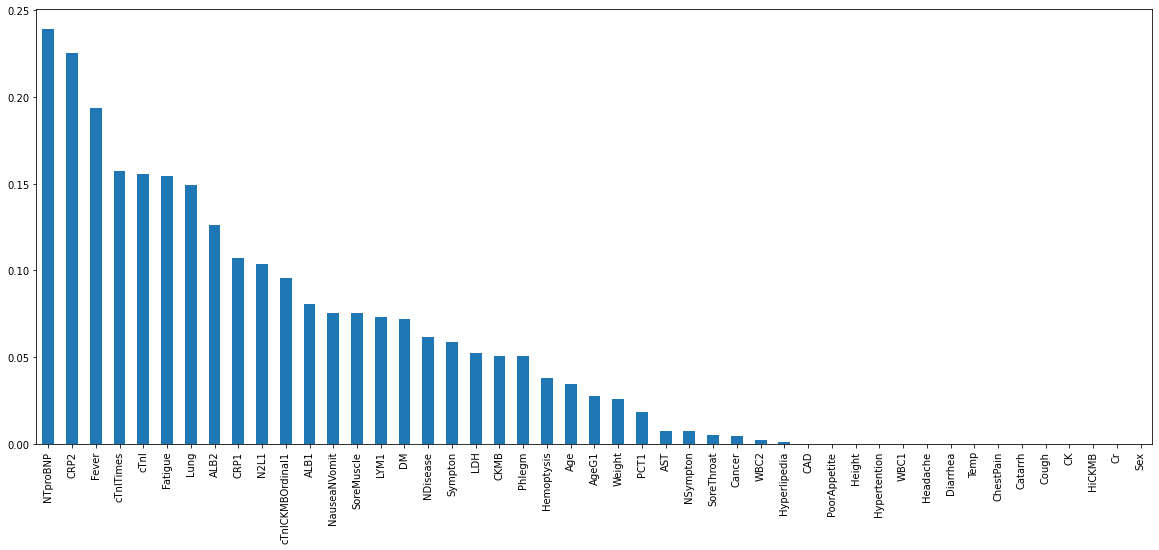

In [52]:
mi.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [53]:
sel_ = SelectKBest(mutual_info_classif, k = 40).fit(X_train, y_train)

In [54]:
mi_features = list(X_train.columns[ ~ sel_.get_support()].values)

In [55]:
for i in mi_features:
    if i in categorical_features:
        mi_features.remove(i)

In [56]:
for i in mi_features:
    if i in numerical_features:
        numerical_features.remove(i)

for i in mi_features:
    if i in categorical_features:
        categorical_features.remove(i)

In [57]:
mi_features

['Height', 'CK', 'HiCKMB', 'Cr', 'PCT1', 'WBC1']

In [58]:
X_train.drop(labels=mi_features, axis=1, inplace=True)
X_test.drop(labels=mi_features, axis=1, inplace=True)

d:\anaconda3\envs\covid-19\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [59]:
X_train.shape, X_test.shape

((77, 41), (9, 41))

#### 3.3.2 Fisher Score

In [60]:
from sklearn.feature_selection import chi2

categorical features

In [61]:
f_score = chi2(X_train[categorical_features], y_train)

The smaller ones have more correlations

In [62]:
p_values = pd.Series(f_score[1])
p_values.index = X_train[categorical_features].columns
p_values.sort_values(ascending=False)

Cancer          0.887949
SoreThroat      0.842057
Cough           0.703238
Headache        0.638344
Hemoptysis      0.594525
NauseaNVomit    0.356552
ChestPain       0.356552
Diarrhea        0.333947
Sex             0.302537
Fever           0.202574
Catarrh         0.159040
Hypertention    0.154388
SoreMuscle      0.105717
Hyperlipedia    0.099153
Lung            0.062605
PoorAppetite    0.060289
Phlegm          0.046410
AgeG1           0.037459
DM              0.008457
Fatigue         0.000049
dtype: float64

In [63]:
p_values[p_values<0.05].index.values

array(['AgeG1', 'Phlegm', 'Fatigue', 'DM'], dtype=object)

In [64]:
# for c in categorical_features:
#     if c not in p_values[p_values<0.05].index.values:
#         categorical_features.remove(c)
#         print(c)
#         X_train.drop(labels=c, axis=1, inplace=True)
#         X_test.drop(labels=c, axis=1, inplace=True)

In [65]:
X_train.shape, X_test.shape

((77, 41), (9, 41))

#### 3.3.3 Univariate

Non-categorical features

In [66]:
from sklearn.feature_selection import f_classif, f_regression

In [67]:
univariate = f_classif(X_train[numerical_features], y_train)
univariate = pd.Series(univariate[1])
univariate.index = X_train[numerical_features].columns
univariate.sort_values(ascending=False, inplace=True)

<AxesSubplot:>

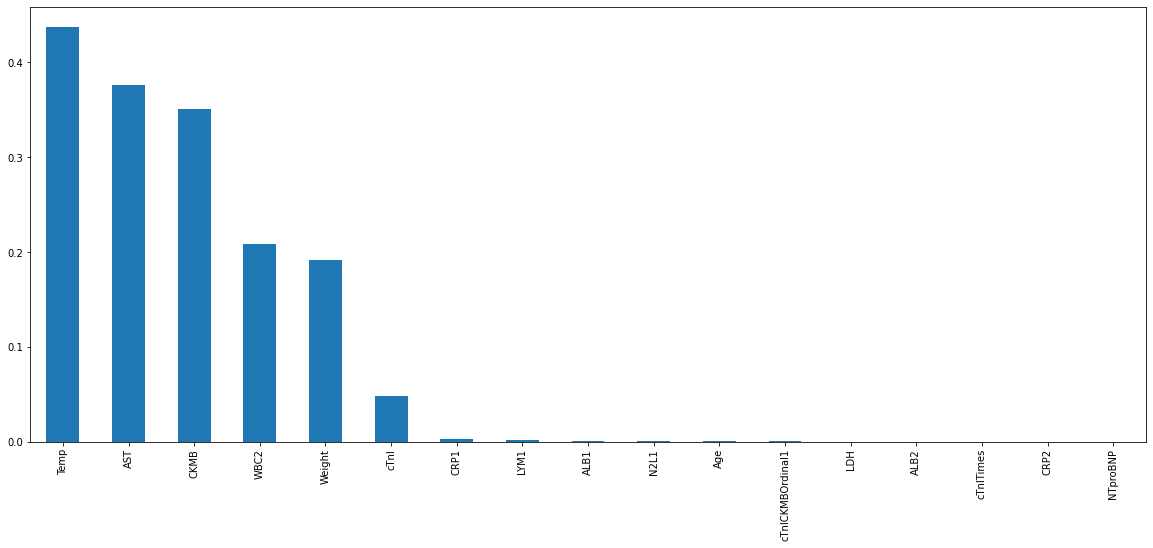

In [68]:
univariate.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [69]:
univariate[univariate > 0.05]

Temp      0.437049
AST       0.376614
CKMB      0.351257
WBC2      0.207957
Weight    0.191531
dtype: float64

In [70]:
for n in numerical_features:
    if n in univariate[univariate > 0.05].index.values:
        numerical_features.remove(n)
        print(n)
        X_train.drop(labels=n, axis=1, inplace=True)
        X_test.drop(labels=n, axis=1, inplace=True)

Weight
AST
CKMB
WBC2


d:\anaconda3\envs\covid-19\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
d:\anaconda3\envs\covid-19\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
d:\anaconda3\envs\covid-19\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
d:\anaconda3\envs\covi

In [71]:
X_train.shape

(77, 37)

#### 3.3.4 ROC-AUC

In [72]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

In [73]:
# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set

roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

In [74]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False)

cTnITimes           0.775
CRP2                0.675
Fever               0.675
SoreThroat          0.650
NTproBNP            0.650
Headache            0.625
LYM1                0.625
N2L1                0.625
ALB2                0.625
NSympton            0.600
AgeG1               0.550
Fatigue             0.500
ChestPain           0.500
NauseaNVomit        0.500
PoorAppetite        0.500
Hemoptysis          0.500
Age                 0.500
Phlegm              0.500
Lung                0.500
Diarrhea            0.500
CAD                 0.500
CRP1                0.500
cTnICKMBOrdinal1    0.500
cTnI                0.500
SoreMuscle          0.500
LDH                 0.500
Sex                 0.450
ALB1                0.450
Hypertention        0.425
Hyperlipedia        0.400
DM                  0.400
Cancer              0.400
Catarrh             0.375
Sympton             0.375
NDisease            0.375
Cough               0.325
Temp                0.175
dtype: float64

<AxesSubplot:>

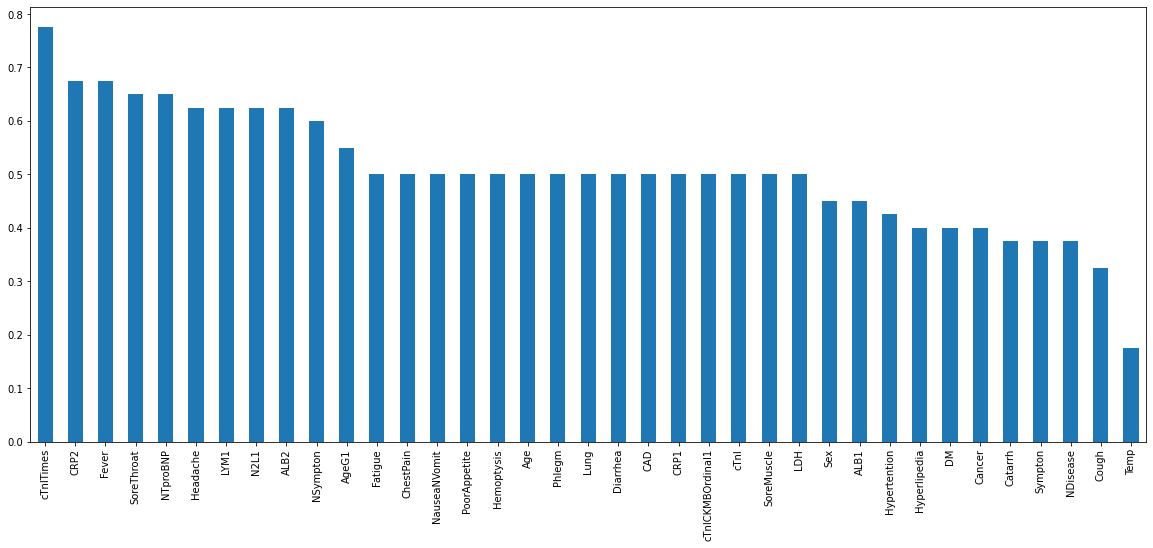

In [75]:
# and now let's plot
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [76]:
# a roc auc value of 0.5 indicates random decision
# let's check how many features show a roc-auc value
# higher than random

len(roc_values[roc_values > 0.5])

11

In [77]:
roc_values[roc_values < 0.5]

Sex             0.450
Temp            0.175
LDH             0.500
ALB1            0.450
Sympton         0.375
Cough           0.325
Catarrh         0.375
Hypertention    0.425
Hyperlipedia    0.400
DM              0.400
Cancer          0.400
NDisease        0.375
dtype: float64

In [78]:
roc_features = roc_values[roc_values < 0.5].index.values

In [79]:
for i in roc_features:
    if i in numerical_features:
        numerical_features.remove(i)

for i in roc_features:
    if i in categorical_features:
        categorical_features.remove(i)

In [80]:
roc_features

array(['Sex', 'Temp', 'LDH', 'ALB1', 'Sympton', 'Cough', 'Catarrh',
       'Hypertention', 'Hyperlipedia', 'DM', 'Cancer', 'NDisease'],
      dtype=object)

In [81]:
# X_train.drop(labels=roc_features, axis=1, inplace=True)
# X_test.drop(labels=roc_features, axis=1, inplace=True)

In [82]:
X_train.shape, X_test.shape

((77, 37), (9, 37))

## 4. Classifier

In [83]:
import sklearn
import sklearn.ensemble
import sklearn.metrics
import xgboost as xgb

**Cross Validation**

In [84]:
from sklearn.model_selection import cross_val_score

In [85]:
def cv_score(classifier, X, y, scoring):
    return cross_val_score(classifier, X, y, cv=5, scoring=scoring)

**Decision Tree**

In [86]:
dt = sklearn.tree.DecisionTreeClassifier()

dt_f1 = cv_score(dt, X_train, y_train, 'f1')

dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [194]:
print(np.mean(dt_f1))

0.5476190476190477


**Random Forest**

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)

rf_f1 = cv_score(rf, X_train, y_train, 'f1')

rf.fit(X_train, y_train)

RandomForestClassifier()

In [90]:
print(np.mean(rf_f1))

0.621904761904762


**XGBoost**

In [92]:
# Create a model
# Params from: https://www.kaggle.com/aharless/swetha-s-xgboost-revised
xgbc = xgb.XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    objective = 'binary:logistic'
)

xgbc_f1 = cv_score(xgbc, X_train, y_train, 'f1')

# Fit the models
xgbc.fit(np.array(X_train), np.array(y_train))

[19:24:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

d:\anaconda3\envs\covid-19\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
d:\anaconda3\envs\covid-19\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
d:\anaconda3\envs\covid-19\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=4, reg_lambda=1, scale_pos_weight=9, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [193]:
print(np.mean(xgbc_f1))

0.6714285714285714


**Neural Networks**

In [145]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [146]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

In [147]:
def build_classifier() :
    nn = Sequential()
    nn.add(Dense(activation='relu', input_dim=X_train.shape[1], units=10))
    nn.add(Dropout(rate = 0.1))
    nn.add(Dense(kernel_initializer="uniform", activation='relu', units=15))
    nn.add(Dropout(rate = 0.1))
    nn.add(Dense(kernel_initializer="uniform", activation='relu', units=5))
    nn.add(Dropout(rate = 0.1))
    nn.add(Dense(kernel_initializer='uniform',activation='sigmoid', units=1))
    nn.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
    return nn

In [148]:
nn = KerasClassifier(build_fn=build_classifier, batch_size=50, epochs=800)
# nn = build_classifier();

In [149]:
history = nn.fit(X_train, y_train, batch_size=50, epochs=800, validation_split = 0.2, verbose=0) 

In [150]:
import eli5
from eli5.sklearn import PermutationImportance

In [151]:
nn_results = PermutationImportance(nn, cv="prefit").fit(X_train, y_train)
nn_importance = nn_results.feature_importances_

2/2 [==============================] - 0s 2ms/step - loss: 0.1256 - accuracy: 0.9481


In [152]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


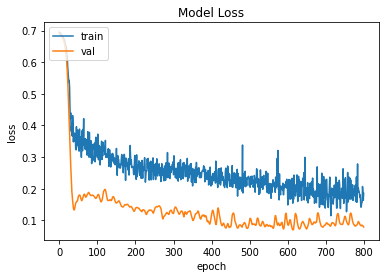

In [153]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'],loc='upper left')
plt.show()

In [101]:
nn_f1 = cv_score(nn, X_train, y_train, 'f1')

Epoch 1/800
2/2 [==============================] - 1s 2ms/step - loss: 0.6915 - accuracy: 0.6966
Epoch 2/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.8198
Epoch 3/800
2/2 [==============================] - 0s 3ms/step - loss: 0.6848 - accuracy: 0.6923
Epoch 4/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6855 - accuracy: 0.7361
Epoch 5/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6812 - accuracy: 0.8131
Epoch 6/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6790 - accuracy: 0.8750
Epoch 7/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6740 - accuracy: 0.8859
Epoch 8/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6669 - accuracy: 0.8307
Epoch 9/800
2/2 [==============================] - 0s 1ms/step - loss: 0.6640 - accuracy: 0.7737
Epoch 10/800
2/2 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.8022
Epoch 11/800
2/2 [===========

2/2 [==============================] - 0s 998us/step - loss: 0.2703 - accuracy: 0.8792
Epoch 167/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2456 - accuracy: 0.8550
Epoch 168/800
2/2 [==============================] - 0s 1ms/step - loss: 0.3020 - accuracy: 0.8726
Epoch 169/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2358 - accuracy: 0.8792
Epoch 170/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2373 - accuracy: 0.9187
Epoch 171/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2309 - accuracy: 0.8902
Epoch 172/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2863 - accuracy: 0.8835
Epoch 173/800
2/2 [==============================] - 0s 2ms/step - loss: 0.3061 - accuracy: 0.8240
Epoch 174/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2713 - accuracy: 0.9472
Epoch 175/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2894 - accuracy: 0.8483
Epoch 176/800
2/2 [===

2/2 [==============================] - 0s 1ms/step - loss: 0.2520 - accuracy: 0.8507
Epoch 331/800
2/2 [==============================] - 0s 1ms/step - loss: 0.2459 - accuracy: 0.9035
Epoch 332/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2788 - accuracy: 0.8835
Epoch 333/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2723 - accuracy: 0.8902
Epoch 334/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2434 - accuracy: 0.8968
Epoch 335/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2458 - accuracy: 0.9078
Epoch 336/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2521 - accuracy: 0.8768
Epoch 337/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2356 - accuracy: 0.8726
Epoch 338/800
2/2 [==============================] - 0s 996us/step - loss: 0.2517 - accuracy: 0.8616
Epoch 339/800
2/2 [==============================] - 0s 1000us/step - loss: 0.2842 - accuracy: 0.8726
Epoch 340/800
2/2 [

2/2 [==============================] - 0s 2ms/step - loss: 0.2290 - accuracy: 0.8835
Epoch 495/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1924 - accuracy: 0.9187
Epoch 496/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2493 - accuracy: 0.8726
Epoch 497/800
2/2 [==============================] - 0s 998us/step - loss: 0.2919 - accuracy: 0.8483
Epoch 498/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2723 - accuracy: 0.8483
Epoch 499/800
2/2 [==============================] - 0s 3ms/step - loss: 0.1825 - accuracy: 0.8835
Epoch 500/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2186 - accuracy: 0.9011
Epoch 501/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2333 - accuracy: 0.8483
Epoch 502/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2436 - accuracy: 0.8659
Epoch 503/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2230 - accuracy: 0.9078
Epoch 504/800
2/2 [===

2/2 [==============================] - 0s 2ms/step - loss: 0.2174 - accuracy: 0.8726
Epoch 659/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2269 - accuracy: 0.8902
Epoch 660/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2230 - accuracy: 0.9120
Epoch 661/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2534 - accuracy: 0.8659
Epoch 662/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2487 - accuracy: 0.8483
Epoch 663/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2371 - accuracy: 0.8902
Epoch 664/800
2/2 [==============================] - 0s 1ms/step - loss: 0.2741 - accuracy: 0.8768
Epoch 665/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2243 - accuracy: 0.8944
Epoch 666/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2188 - accuracy: 0.8902
Epoch 667/800
2/2 [==============================] - 0s 999us/step - loss: 0.1969 - accuracy: 0.9144
Epoch 668/800
2/2 [===

d:\anaconda3\envs\covid-19\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.5364
Epoch 2/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6918 - accuracy: 0.7889
Epoch 3/800
2/2 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.7889
Epoch 4/800
2/2 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.7955
Epoch 5/800
2/2 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.8022
Epoch 6/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6868 - accuracy: 0.8155
Epoch 7/800
2/2 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.7955
Epoch 8/800
2/2 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.8022
Epoch 9/800
2/2 [==============================] - 0s 1ms/step - loss: 0.6818 - accuracy: 0.7955
Epoch 10/800
2/2 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.8089
Epoch 11/800
2/2 [===========

2/2 [==============================] - 0s 2ms/step - loss: 0.2476 - accuracy: 0.9120
Epoch 168/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1801 - accuracy: 0.9254
Epoch 169/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2250 - accuracy: 0.9120
Epoch 170/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2090 - accuracy: 0.9430
Epoch 171/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2324 - accuracy: 0.9120
Epoch 172/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2829 - accuracy: 0.9120
Epoch 173/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2453 - accuracy: 0.9120
Epoch 174/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2507 - accuracy: 0.9187
Epoch 175/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2630 - accuracy: 0.8944
Epoch 176/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2525 - accuracy: 0.9120
Epoch 177/800
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.2303 - accuracy: 0.9296
Epoch 332/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2192 - accuracy: 0.8944
Epoch 333/800
2/2 [==============================] - 0s 3ms/step - loss: 0.1845 - accuracy: 0.9296
Epoch 334/800
2/2 [==============================] - 0s 1ms/step - loss: 0.1744 - accuracy: 0.9187
Epoch 335/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1703 - accuracy: 0.8902
Epoch 336/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1662 - accuracy: 0.9144
Epoch 337/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2200 - accuracy: 0.9363
Epoch 338/800
2/2 [==============================] - 0s 4ms/step - loss: 0.2187 - accuracy: 0.9296
Epoch 339/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2418 - accuracy: 0.9011
Epoch 340/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2205 - accuracy: 0.9120
Epoch 341/800
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 0.2268 - accuracy: 0.9296
Epoch 496/800
2/2 [==============================] - 0s 3ms/step - loss: 0.1527 - accuracy: 0.9430
Epoch 497/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2025 - accuracy: 0.9296
Epoch 498/800
2/2 [==============================] - 0s 3ms/step - loss: 0.1953 - accuracy: 0.9363
Epoch 499/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2384 - accuracy: 0.9363
Epoch 500/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2279 - accuracy: 0.9363
Epoch 501/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1546 - accuracy: 0.9363
Epoch 502/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1962 - accuracy: 0.9296
Epoch 503/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1976 - accuracy: 0.9363
Epoch 504/800
2/2 [==============================] - 0s 16ms/step - loss: 0.1809 - accuracy: 0.9296
Epoch 505/800
2/2 [====

2/2 [==============================] - 0s 2ms/step - loss: 0.1980 - accuracy: 0.9363
Epoch 660/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2095 - accuracy: 0.9296
Epoch 661/800
2/2 [==============================] - 0s 3ms/step - loss: 0.1924 - accuracy: 0.9296
Epoch 662/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1674 - accuracy: 0.9363
Epoch 663/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1445 - accuracy: 0.9363
Epoch 664/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2130 - accuracy: 0.9363
Epoch 665/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1889 - accuracy: 0.9296
Epoch 666/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1788 - accuracy: 0.9363
Epoch 667/800
2/2 [==============================] - 0s 3ms/step - loss: 0.1727 - accuracy: 0.9430
Epoch 668/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2271 - accuracy: 0.9296
Epoch 669/800
2/2 [=====

d:\anaconda3\envs\covid-19\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/800
2/2 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5845
Epoch 2/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5348
Epoch 3/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6950 - accuracy: 0.5563
Epoch 4/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6811 - accuracy: 0.6153
Epoch 5/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6856 - accuracy: 0.5656
Epoch 6/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6724 - accuracy: 0.6809
Epoch 7/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6740 - accuracy: 0.7480
Epoch 8/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6743 - accuracy: 0.7239
Epoch 9/800
2/2 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.7049
Epoch 10/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6576 - accuracy: 0.7520
Epoch 11/800
2/2 [===========

Epoch 167/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2425 - accuracy: 0.8566
Epoch 168/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2270 - accuracy: 0.8914
Epoch 169/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2540 - accuracy: 0.8673
Epoch 170/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2231 - accuracy: 0.8673
Epoch 171/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2346 - accuracy: 0.8673
Epoch 172/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2446 - accuracy: 0.8781
Epoch 173/800
2/2 [==============================] - 0s 1ms/step - loss: 0.2194 - accuracy: 0.8740
Epoch 174/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2376 - accuracy: 0.8632
Epoch 175/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2747 - accuracy: 0.8673
Epoch 176/800
2/2 [==============================] - 0s 3ms/step - loss: 0.1836 - accuracy: 0.8914
Epoch 177/

2/2 [==============================] - 0s 2ms/step - loss: 0.1758 - accuracy: 0.8740
Epoch 332/800
2/2 [==============================] - 0s 3ms/step - loss: 0.1850 - accuracy: 0.8914
Epoch 333/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1837 - accuracy: 0.8847
Epoch 334/800
2/2 [==============================] - 0s 3ms/step - loss: 0.1718 - accuracy: 0.9022
Epoch 335/800
2/2 [==============================] - 0s 3ms/step - loss: 0.1575 - accuracy: 0.9088
Epoch 336/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1609 - accuracy: 0.8740
Epoch 337/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2143 - accuracy: 0.8781
Epoch 338/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1688 - accuracy: 0.9088
Epoch 339/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1762 - accuracy: 0.8914
Epoch 340/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2055 - accuracy: 0.8606
Epoch 341/800
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1762 - accuracy: 0.8740
Epoch 496/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2005 - accuracy: 0.9022
Epoch 497/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1544 - accuracy: 0.8806
Epoch 498/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1421 - accuracy: 0.8981
Epoch 499/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1628 - accuracy: 0.8981
Epoch 500/800
2/2 [==============================] - 0s 3ms/step - loss: 0.1684 - accuracy: 0.8781
Epoch 501/800
2/2 [==============================] - 0s 3ms/step - loss: 0.1427 - accuracy: 0.8981
Epoch 502/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1569 - accuracy: 0.9129
Epoch 503/800
2/2 [==============================] - 0s 3ms/step - loss: 0.1466 - accuracy: 0.9022
Epoch 504/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1822 - accuracy: 0.8955
Epoch 505/800
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 0.1619 - accuracy: 0.9022
Epoch 660/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1392 - accuracy: 0.9155
Epoch 661/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1671 - accuracy: 0.8781
Epoch 662/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1481 - accuracy: 0.9022
Epoch 663/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1607 - accuracy: 0.9196
Epoch 664/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1688 - accuracy: 0.9022
Epoch 665/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1572 - accuracy: 0.9022
Epoch 666/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1703 - accuracy: 0.8847
Epoch 667/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1370 - accuracy: 0.9155
Epoch 668/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1699 - accuracy: 0.8847
Epoch 669/800
2/2 [=====

d:\anaconda3\envs\covid-19\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/800
2/2 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.7587
Epoch 2/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6905 - accuracy: 0.8217
Epoch 3/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6876 - accuracy: 0.8284
Epoch 4/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6836 - accuracy: 0.8217
Epoch 5/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6789 - accuracy: 0.8351
Epoch 6/800
2/2 [==============================] - 0s 999us/step - loss: 0.6742 - accuracy: 0.8284
Epoch 7/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6678 - accuracy: 0.8217
Epoch 8/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6601 - accuracy: 0.8351
Epoch 9/800
2/2 [==============================] - 0s 1ms/step - loss: 0.6579 - accuracy: 0.8391
Epoch 10/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6489 - accuracy: 0.8391
Epoch 11/800
2/2 [=========

2/2 [==============================] - 0s 3ms/step - loss: 0.2536 - accuracy: 0.9022
Epoch 168/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2591 - accuracy: 0.9022
Epoch 169/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2165 - accuracy: 0.9022
Epoch 170/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2749 - accuracy: 0.9129
Epoch 171/800
2/2 [==============================] - 0s 2ms/step - loss: 0.3157 - accuracy: 0.8499
Epoch 172/800
2/2 [==============================] - 0s 3ms/step - loss: 0.3257 - accuracy: 0.8432
Epoch 173/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2897 - accuracy: 0.8955
Epoch 174/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2449 - accuracy: 0.9196
Epoch 175/800
2/2 [==============================] - 0s 4ms/step - loss: 0.2664 - accuracy: 0.9022
Epoch 176/800
2/2 [==============================] - 0s 4ms/step - loss: 0.2649 - accuracy: 0.9262
Epoch 177/800
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 0.2705 - accuracy: 0.8955
Epoch 332/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2316 - accuracy: 0.9088
Epoch 333/800
2/2 [==============================] - 0s 4ms/step - loss: 0.2841 - accuracy: 0.8847
Epoch 334/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2467 - accuracy: 0.9262
Epoch 335/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2554 - accuracy: 0.9129
Epoch 336/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2319 - accuracy: 0.9303
Epoch 337/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2556 - accuracy: 0.8781
Epoch 338/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2329 - accuracy: 0.9196
Epoch 339/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2404 - accuracy: 0.8981
Epoch 340/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2339 - accuracy: 0.9303
Epoch 341/800
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 0.2019 - accuracy: 0.9437
Epoch 496/800
2/2 [==============================] - 0s 4ms/step - loss: 0.2021 - accuracy: 0.9262
Epoch 497/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1708 - accuracy: 0.9370
Epoch 498/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2127 - accuracy: 0.9303
Epoch 499/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2338 - accuracy: 0.8847
Epoch 500/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2448 - accuracy: 0.9129
Epoch 501/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2250 - accuracy: 0.9196
Epoch 502/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2488 - accuracy: 0.9370
Epoch 503/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2558 - accuracy: 0.9129
Epoch 504/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2202 - accuracy: 0.9303
Epoch 505/800
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.1913 - accuracy: 0.9129
Epoch 660/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2285 - accuracy: 0.9303
Epoch 661/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2720 - accuracy: 0.8740
Epoch 662/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1867 - accuracy: 0.9370
Epoch 663/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2265 - accuracy: 0.9370
Epoch 664/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2211 - accuracy: 0.9196
Epoch 665/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2234 - accuracy: 0.9196
Epoch 666/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2193 - accuracy: 0.9303
Epoch 667/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2451 - accuracy: 0.8955
Epoch 668/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2410 - accuracy: 0.9303
Epoch 669/800
2/2 [=====

d:\anaconda3\envs\covid-19\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/800
2/2 [==============================] - 0s 998us/step - loss: 0.6943 - accuracy: 0.5804
Epoch 2/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.5563
Epoch 3/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6886 - accuracy: 0.5697
Epoch 4/800
2/2 [==============================] - 0s 1ms/step - loss: 0.6854 - accuracy: 0.7024
Epoch 5/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6893 - accuracy: 0.6916
Epoch 6/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6841 - accuracy: 0.7131
Epoch 7/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6788 - accuracy: 0.6824
Epoch 8/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6758 - accuracy: 0.7413
Epoch 9/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6712 - accuracy: 0.7346
Epoch 10/800
2/2 [==============================] - 0s 2ms/step - loss: 0.6712 - accuracy: 0.7587
Epoch 11/800
2/2 [=========

2/2 [==============================] - 0s 4ms/step - loss: 0.2678 - accuracy: 0.8258
Epoch 167/800
2/2 [==============================] - 0s 2ms/step - loss: 0.3694 - accuracy: 0.8151
Epoch 168/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2907 - accuracy: 0.8325
Epoch 169/800
2/2 [==============================] - 0s 3ms/step - loss: 0.3356 - accuracy: 0.8043
Epoch 170/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2867 - accuracy: 0.8673
Epoch 171/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2648 - accuracy: 0.8781
Epoch 172/800
2/2 [==============================] - 0s 1000us/step - loss: 0.2851 - accuracy: 0.8673
Epoch 173/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2934 - accuracy: 0.8217
Epoch 174/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2742 - accuracy: 0.8325
Epoch 175/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2886 - accuracy: 0.8566
Epoch 176/800
2/2 [==

2/2 [==============================] - 0s 2ms/step - loss: 0.2453 - accuracy: 0.8499
Epoch 331/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2432 - accuracy: 0.8699
Epoch 332/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2255 - accuracy: 0.8632
Epoch 333/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2009 - accuracy: 0.8566
Epoch 334/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2180 - accuracy: 0.8740
Epoch 335/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2494 - accuracy: 0.8740
Epoch 336/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2769 - accuracy: 0.8217
Epoch 337/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2911 - accuracy: 0.8391
Epoch 338/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2795 - accuracy: 0.8391
Epoch 339/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2716 - accuracy: 0.8325
Epoch 340/800
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.2176 - accuracy: 0.8499
Epoch 495/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2167 - accuracy: 0.8458
Epoch 496/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2161 - accuracy: 0.8432
Epoch 497/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2249 - accuracy: 0.8806
Epoch 498/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2104 - accuracy: 0.8566
Epoch 499/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2367 - accuracy: 0.8632
Epoch 500/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2289 - accuracy: 0.8781
Epoch 501/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2386 - accuracy: 0.8847
Epoch 502/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2574 - accuracy: 0.9022
Epoch 503/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2292 - accuracy: 0.9088
Epoch 504/800
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.2036 - accuracy: 0.8673
Epoch 659/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2212 - accuracy: 0.8591
Epoch 660/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2295 - accuracy: 0.8499
Epoch 661/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1855 - accuracy: 0.9262
Epoch 662/800
2/2 [==============================] - 0s 3ms/step - loss: 0.1764 - accuracy: 0.8806
Epoch 663/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2188 - accuracy: 0.8632
Epoch 664/800
2/2 [==============================] - 0s 2ms/step - loss: 0.1967 - accuracy: 0.8673
Epoch 665/800
2/2 [==============================] - 0s 3ms/step - loss: 0.2396 - accuracy: 0.9022
Epoch 666/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2333 - accuracy: 0.8955
Epoch 667/800
2/2 [==============================] - 0s 2ms/step - loss: 0.2186 - accuracy: 0.8981
Epoch 668/800
2/2 [=====

d:\anaconda3\envs\covid-19\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [192]:
print(np.mean(nn_f1))

0.579047619047619


## 6. Results

Save Models

In [404]:
import pickle

In [407]:
with open("model/model-3.pkl", 'wb') as f:
    pickle.dump([dt, rf, xgbc], f)
# with open("model-4.pkl", 'wb') as f:
#     pickle.dump([dt, rf, xgbc, nn], f)
with open("dataset/dataset.pkl", 'wb') as f:
    pickle.dump([X_train, X_test, y_train, y_test], f)

In [406]:
nn.model.save('nn.h5')

Load Keras Model

In [106]:
from keras.models import load_model

In [107]:
nn = load_model("model/nn.h5")

Load Models

In [108]:
with open("model/model-3.pkl", 'rb') as f:
    [dt, rf, xgbc] = pickle.load(f)

In [ ]:
with open("model/model-4.pkl", 'rb') as f:
    [dt, rf, xgbc, nn] = pickle.load(f)

Load Dataset

In [109]:
with open("dataset/dataset.pkl", 'rb') as f:
    [X_train, X_test, y_train, y_test] = pickle.load(f)

**Prediction**

In [173]:
import numpy as np
import sklearn

In [174]:
dt_pred = dt.predict(X_test)

rf_pred = rf.predict(X_test)
xgbc_pred = xgbc.predict(np.array(X_test))

nn_pred = nn.predict(X_test)
nn_pred[nn_pred > 0.5] = 1
nn_pred[nn_pred <= 0.5] = 0

d:\anaconda3\envs\covid-19\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [175]:
import math

In [176]:
print("Decision Tree")
print("Precision: ", sklearn.metrics.accuracy_score(y_test, dt_pred))
print("Recal: ", sklearn.metrics.recall_score(y_test, dt_pred))
print("F1: ", sklearn.metrics.f1_score(y_test, dt_pred))
print("CI:", 1.96 * math.sqrt( ((1 - sklearn.metrics.accuracy_score(y_test, dt_pred)) * (sklearn.metrics.accuracy_score(y_test, dt_pred))) / len(X_test)))

print()

print("Random Forest")
print("Precision: ", sklearn.metrics.accuracy_score(y_test, rf_pred))
print("Recal: ", sklearn.metrics.recall_score(y_test, rf_pred))
print("F1: ", sklearn.metrics.f1_score(y_test, rf_pred))
print("CI:", 1.96 * math.sqrt( ((1 - sklearn.metrics.accuracy_score(y_test, rf_pred)) * (sklearn.metrics.accuracy_score(y_test, rf_pred))) / len(X_test)))

print()

print("XGBoost")
print("Precision: ", sklearn.metrics.accuracy_score(y_test, xgbc_pred))
print("Recal: ", sklearn.metrics.recall_score(y_test, xgbc_pred))
print("F1: ", sklearn.metrics.f1_score(y_test, xgbc_pred))
print("CI:", 1.96 * math.sqrt( ((1 - sklearn.metrics.accuracy_score(y_test, xgbc_pred)) * (sklearn.metrics.accuracy_score(y_test, xgbc_pred))) / len(X_test)))

print()

print("NN")
print("Precision: ", sklearn.metrics.accuracy_score(y_test, nn_pred))
print("Recal: ", sklearn.metrics.recall_score(y_test, nn_pred))
print("F1: ", sklearn.metrics.f1_score(y_test, nn_pred))
print("CI:", 1.96 * math.sqrt( ((1 - sklearn.metrics.accuracy_score(y_test, nn_pred)) * (sklearn.metrics.accuracy_score(y_test, nn_pred))) / len(X_test)))


Decision Tree
Precision:  0.6666666666666666
Recal:  0.5
F1:  0.5714285714285715
CI: 0.3079842869168074

Random Forest
Precision:  0.6666666666666666
Recal:  0.5
F1:  0.5714285714285715
CI: 0.3079842869168074

XGBoost
Precision:  0.7777777777777778
Recal:  1.0
F1:  0.8
CI: 0.27161661029914536

NN
Precision:  0.7777777777777778
Recal:  1.0
F1:  0.8
CI: 0.27161661029914536


In [177]:
print("dt:\t", dt_pred)
print("rf:\t", rf_pred)
print("xgbc:\t", xgbc_pred)
print("nn:\t", nn_pred.reshape(len(nn_pred)).astype("uint8"))

print("y_t:\t", y_test)

dt:	 [0 1 1 0 1 0 0 0 0]
rf:	 [0 0 1 0 1 0 0 1 0]
xgbc:	 [0 1 1 0 1 1 1 1 0]
nn:	 [0 1 1 0 1 1 1 1 0]
y_t:	 [0 1 0 0 1 1 0 1 0]


## 7. Explain

### 7.1 Permutation Feature Importance

In [178]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

In [179]:
fi = {}
fi["dt"] = []
fi["rf"] = []
fi["xgbc"] = []
fi["nn"] = []

**Decision Tree**

In [180]:
dt_results = permutation_importance(dt, X_train, y_train, scoring='accuracy')
dt_importance = dt_results.importances_mean
for i,v in enumerate(dt_importance):
    if v != 0:
        fi["dt"].append({
            'name': X_train.columns[i],
            'value': v
        })

In [181]:
fi["dt"] = sorted(fi["dt"], key=lambda x: x['value'], reverse=True)

**Random Forests**

In [182]:
rf_results = permutation_importance(rf, X_train, y_train, scoring='accuracy')
rf_importance = rf_results.importances_mean
for i,v in enumerate(rf_importance):
    if v != 0:
        fi["rf"].append({
            'name': X_train.columns[i],
            'value': v
        })

In [183]:
fi["rf"] = sorted(fi["rf"], key=lambda x: x['value'], reverse=True)

**Gradient Boosted Trees**

In [184]:
xgbc_results = permutation_importance(xgbc, np.array(X_train), np.array(y_train), scoring='accuracy')
xgbc_importance = xgbc_results.importances_mean
for i,v in enumerate(xgbc_importance):
    if v != 0:
        fi["xgbc"].append({
            'name': X_train.columns[i],
            'value': v
        })

In [185]:
fi["xgbc"] = sorted(fi["xgbc"], key=lambda x: x['value'], reverse=True)

**Neural Networks**

In [186]:
for i,v in enumerate(nn_importance):
    if v != 0:
        fi["nn"].append({
            'name': X_train.columns[i],
            'value': v
        })

In [187]:
fi["nn"] = sorted(fi["nn"], key=lambda x: x['value'], reverse=True)

**Summary**

In [188]:
print("Decision Tree")
for i in fi["dt"]:
    print('Feature: %20s,\t Score: %.3f \t Actual: %.3f' % (i["name"],v, i["value"]))

Decision Tree
Feature:             NTproBNP,	 Score: 0.000 	 Actual: 0.291
Feature:                 CRP2,	 Score: 0.000 	 Actual: 0.068
Feature:                 ALB2,	 Score: 0.000 	 Actual: 0.055
Feature:                 Temp,	 Score: 0.000 	 Actual: 0.049
Feature:              Sympton,	 Score: 0.000 	 Actual: 0.021


In [189]:
print("Random Forests")
for i in fi["rf"]:
    print('Feature: %20s,\t Score: %.3f \t Actual: %.3f' % (i["name"],v, i["value"]))

Random Forests
Feature:                 CRP2,	 Score: 0.000 	 Actual: 0.026
Feature:             NTproBNP,	 Score: 0.000 	 Actual: 0.013
Feature:                 cTnI,	 Score: 0.000 	 Actual: 0.010
Feature:                 LYM1,	 Score: 0.000 	 Actual: 0.010
Feature:                 ALB2,	 Score: 0.000 	 Actual: 0.008
Feature:                  Age,	 Score: 0.000 	 Actual: 0.005
Feature:                 CRP1,	 Score: 0.000 	 Actual: 0.003


In [190]:
print("Gradient Boosted Trees")
for i in fi["xgbc"]:
    print('Feature: %20s,\t Score: %.3f \t Actual: %.3f' % (i["name"],v, i["value"]))

Gradient Boosted Trees
Feature:                 CRP2,	 Score: 0.000 	 Actual: 0.091
Feature:            cTnITimes,	 Score: 0.000 	 Actual: 0.023
Feature:                 LYM1,	 Score: 0.000 	 Actual: 0.016
Feature:             NTproBNP,	 Score: 0.000 	 Actual: 0.013
Feature:               Phlegm,	 Score: 0.000 	 Actual: 0.013
Feature:                  Age,	 Score: 0.000 	 Actual: 0.008
Feature:                 cTnI,	 Score: 0.000 	 Actual: 0.008
Feature:                 ALB2,	 Score: 0.000 	 Actual: 0.008
Feature:              Sympton,	 Score: 0.000 	 Actual: 0.008
Feature:                  LDH,	 Score: 0.000 	 Actual: 0.005
Feature:                   DM,	 Score: 0.000 	 Actual: 0.005
Feature:                 CRP1,	 Score: 0.000 	 Actual: -0.003


In [191]:
print("Neural Networks")
for i in fi["nn"]:
    print('Feature: %20s,\t Score: %.3f \t Actual: %.3f' % (i["name"],v, i["value"]))

Neural Networks
Feature:             NTproBNP,	 Score: 0.000 	 Actual: 0.205
Feature:                 CRP2,	 Score: 0.000 	 Actual: 0.086
Feature:                 CRP1,	 Score: 0.000 	 Actual: 0.034
Feature:                  LDH,	 Score: 0.000 	 Actual: 0.031
Feature:                  Age,	 Score: 0.000 	 Actual: 0.029
Feature:           SoreMuscle,	 Score: 0.000 	 Actual: 0.010
Feature:                 ALB1,	 Score: 0.000 	 Actual: 0.008
Feature:           SoreThroat,	 Score: 0.000 	 Actual: 0.008
Feature:              Fatigue,	 Score: 0.000 	 Actual: 0.008
Feature:                  Sex,	 Score: 0.000 	 Actual: 0.005
Feature:            ChestPain,	 Score: 0.000 	 Actual: 0.005
Feature:            cTnITimes,	 Score: 0.000 	 Actual: 0.003
Feature:                 LYM1,	 Score: 0.000 	 Actual: 0.003
Feature:                 N2L1,	 Score: 0.000 	 Actual: 0.003
Feature:                 ALB2,	 Score: 0.000 	 Actual: 0.003
Feature:               Phlegm,	 Score: 0.000 	 Actual: 0.003


### 7.2 Partial Dependence Plot

In [195]:
from sklearn.inspection import plot_partial_dependence

In [420]:
X_train.columns

Index(['Sex', 'Age', 'AgeG1', 'Temp', 'cTnITimes', 'cTnI', 'cTnICKMBOrdinal1',
       'LDH', 'NTproBNP', 'LYM1', 'N2L1', 'CRP1', 'ALB1', 'CRP2', 'ALB2',
       'Sympton', 'Fever', 'Cough', 'Phlegm', 'Hemoptysis', 'SoreThroat',
       'Catarrh', 'Headache', 'ChestPain', 'Fatigue', 'SoreMuscle', 'Diarrhea',
       'PoorAppetite', 'NauseaNVomit', 'Hypertention', 'Hyperlipedia', 'DM',
       'Lung', 'CAD', 'Cancer', 'NSympton', 'NDisease'],
      dtype='object')

**Decision Tree**

In [590]:
SMALL_SIZE = 16
MEDIUM_SIZE = 24
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE, weight='bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, linewidth='3')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

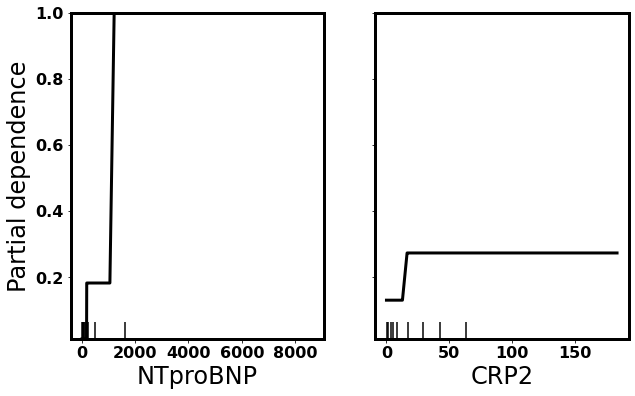

In [591]:
fig, ax = plt.subplots(figsize=(10, 6))
# ax.set_title("Decision Tree", fontsize=25, pad=20)
plot_partial_dependence(dt, X_train, [8, 13], ax=ax, line_kw={"color": "black", "linewidth":"3"})
fig.savefig("dt_pdp_crp_ntproBNP")

**Random Forest**

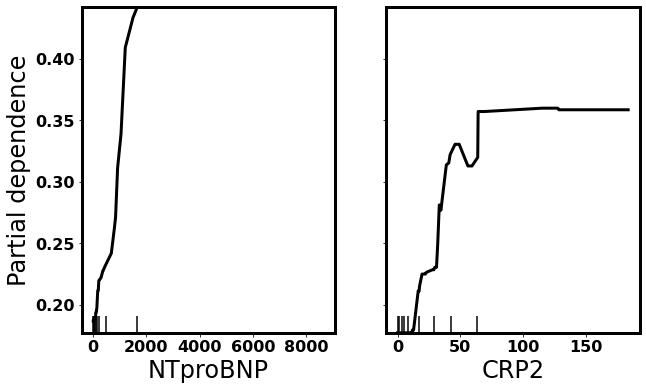

In [592]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_partial_dependence(rf, X_train, [8, 13], ax=ax, line_kw={"color": "black", "linewidth":"3"}) 
fig.savefig("rf_pdp_crp_ntproBNP")

**Gradient Boosted Trees**

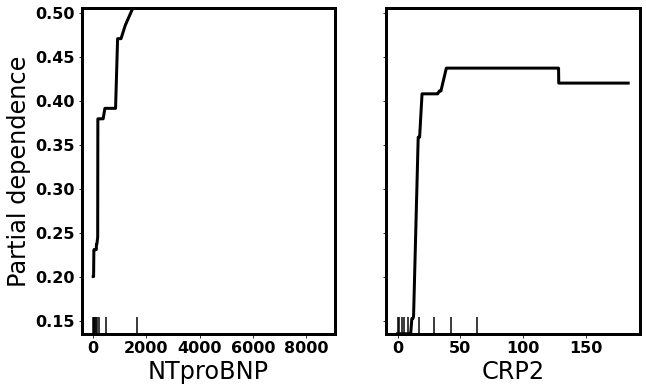

In [593]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_partial_dependence(xgbc, X_train, [8, 13], ax=ax, line_kw={"color": "black", "linewidth":"3"})
# fig = plt.gcf()
# fig.subplots_adjust(hspace=0.3)
fig.savefig("xgbc_pdp_crp_ntproBNP")

**Neural Networks**

In [594]:
nn._estimator_type = 'classifier'

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `

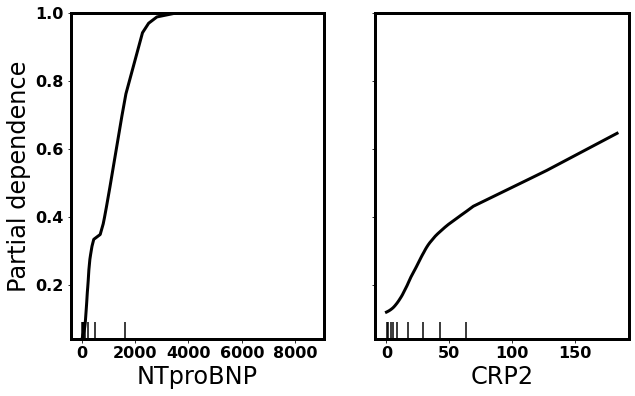

In [595]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_partial_dependence(nn, X_train, [8, 13], ax=ax, line_kw={"color": "black", "linewidth":"3"})
# fig = plt.gcf()
# fig.subplots_adjust(hspace=0.3)
fig.savefig("nn_pdp_crp_ntproBNP")

### 7.3 Individual Conditional Expectation (ICE)

In [596]:
def my_ice(model, X, feat_idx):
#     X = np.array(X)
    fmax, fmin = np.max(np.array(X)[:, feat_idx]), np.min(np.array(X)[:, feat_idx])
    frange = np.linspace(fmin, fmax, 100)
    preds = []
    for x in frange:
        X_ = X.copy()
        X_.iloc[:, feat_idx] = x
        pred = model.predict_proba(X_)
#         print(pred.shape)
        preds.append(pred[:, 1])
    return (frange, np.array(preds))

In [597]:
X_train.columns

Index(['Sex', 'Age', 'AgeG1', 'Temp', 'cTnITimes', 'cTnI', 'cTnICKMBOrdinal1',
       'LDH', 'NTproBNP', 'LYM1', 'N2L1', 'CRP1', 'ALB1', 'CRP2', 'ALB2',
       'Sympton', 'Fever', 'Cough', 'Phlegm', 'Hemoptysis', 'SoreThroat',
       'Catarrh', 'Headache', 'ChestPain', 'Fatigue', 'SoreMuscle', 'Diarrhea',
       'PoorAppetite', 'NauseaNVomit', 'Hypertention', 'Hyperlipedia', 'DM',
       'Lung', 'CAD', 'Cancer', 'NSympton', 'NDisease'],
      dtype='object')

In [598]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE, weight='bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, linewidth='3')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

**Decision Tree**

In [599]:
BNP_data = my_ice(dt, X_train, 8)
CRP_data = my_ice(dt, X_train, 13)

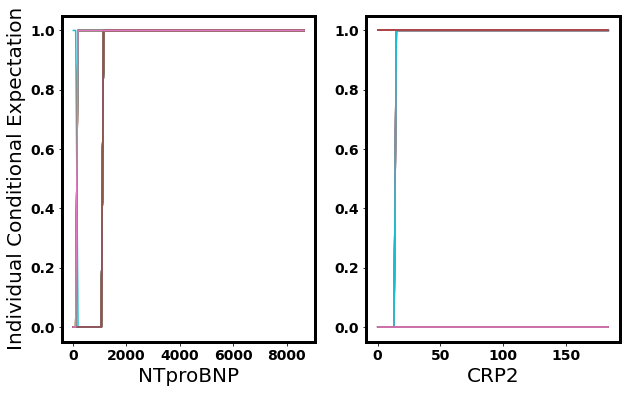

In [600]:
# parameters = {'axes.labelsize': 15,
#           'axes.titlesize': 20}
# plt.rcParams.update(parameters)

f = plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.plot(BNP_data[0], BNP_data[1])
plt.xlabel('NTproBNP')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel('Individual Conditional Expectation')

plt.subplot(122)
plt.plot(CRP_data[0], CRP_data[1])
plt.xlabel('CRP2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

f.savefig('dt_ice_crp_ntproBNP.png')

**Random Forests**

In [601]:
BNP_data = my_ice(rf, X_train, 8)
CRP_data = my_ice(rf, X_train, 13)

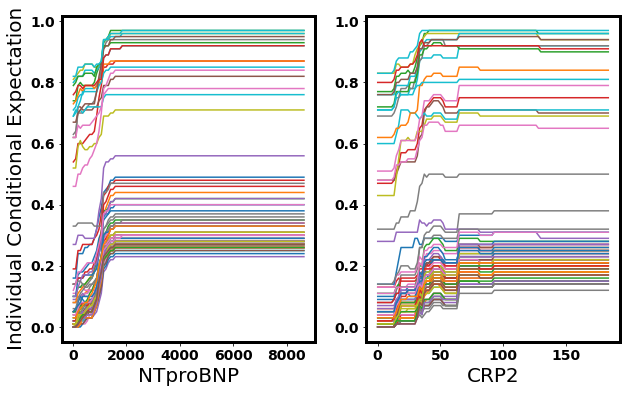

In [602]:
# parameters = {'axes.labelsize': 15,
#           'axes.titlesize': 20}
# plt.rcParams.update(parameters)

f = plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.plot(BNP_data[0], BNP_data[1])
plt.xlabel('NTproBNP')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel('Individual Conditional Expectation')

plt.subplot(122)
plt.plot(CRP_data[0], CRP_data[1])
plt.xlabel('CRP2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

f.savefig('rf_ice_crp_ntproBNP.png')

**Gradient Boosted Trees**

In [603]:
BNP_data = my_ice(xgbc, X_train, 8)
CRP_data = my_ice(xgbc, X_train, 13)

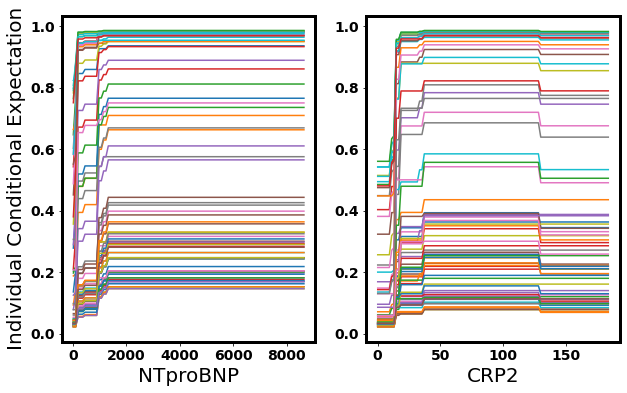

In [604]:
# parameters = {'axes.labelsize': 15,
#           'axes.titlesize': 20}
# plt.rcParams.update(parameters)

f = plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.plot(BNP_data[0], BNP_data[1])
plt.xlabel('NTproBNP')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel('Individual Conditional Expectation')

plt.subplot(122)
plt.plot(CRP_data[0], CRP_data[1])
plt.xlabel('CRP2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

f.savefig('xgbc_ice_crp_ntproBNP.png')

**Neural Networks**

In [605]:
BNP_data = my_ice(nn, X_train, 8)
CRP_data = my_ice(nn, X_train, 13)

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `

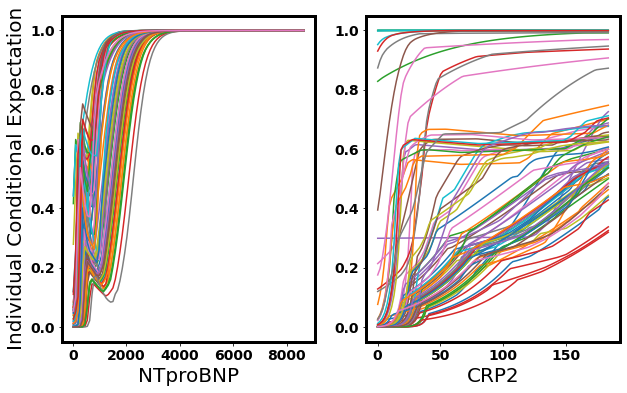

In [606]:
# parameters = {'axes.labelsize': 15,
#           'axes.titlesize': 20}
# plt.rcParams.update(parameters)

f = plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.plot(BNP_data[0], BNP_data[1])
plt.xlabel('NTproBNP')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel('Individual Conditional Expectation')

plt.subplot(122)
plt.plot(CRP_data[0], CRP_data[1])
plt.xlabel('CRP2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

f.savefig('nn_ice_crp_ntproBNP.png')

### 7.4 Accumulated Local Effects (ALE) Plot

In [558]:
from alibi.explainers import ALE, plot_ale

In [564]:
def predict_fn_xbg(X):
    X_data = pd.DataFrame(data=X, columns=xgbc.get_booster().feature_names)
    return xgbc.predict_proba(X_data)

In [569]:
def ale_plot(model, feature_names, target_names, X_train, features):
    my_ale = ALE(model.predict_proba, feature_names=feature_names, target_names=target_names)
    exp = my_ale.explain(X_train.to_numpy())
    plot_ale(exp, features=features, fig_kw={'figwidth':10, 'figheight': 5}, line_kw={"linewidth":"3"})

In [575]:
def ale_plot_xgbc(model, feature_names, target_names, X_train, features):
    my_ale = ALE(predict_fn_xbg, feature_names=feature_names, target_names=target_names)
    exp = my_ale.explain(X_train.to_numpy())
    plot_ale(exp, features=features, fig_kw={'figwidth':10, 'figheight': 5}, line_kw={"linewidth":"3"})

In [571]:
X_train.columns

Index(['Sex', 'Age', 'AgeG1', 'Temp', 'cTnITimes', 'cTnI', 'cTnICKMBOrdinal1',
       'LDH', 'NTproBNP', 'LYM1', 'N2L1', 'CRP1', 'ALB1', 'CRP2', 'ALB2',
       'Sympton', 'Fever', 'Cough', 'Phlegm', 'Hemoptysis', 'SoreThroat',
       'Catarrh', 'Headache', 'ChestPain', 'Fatigue', 'SoreMuscle', 'Diarrhea',
       'PoorAppetite', 'NauseaNVomit', 'Hypertention', 'Hyperlipedia', 'DM',
       'Lung', 'CAD', 'Cancer', 'NSympton', 'NDisease'],
      dtype='object')

**Decision Tree**

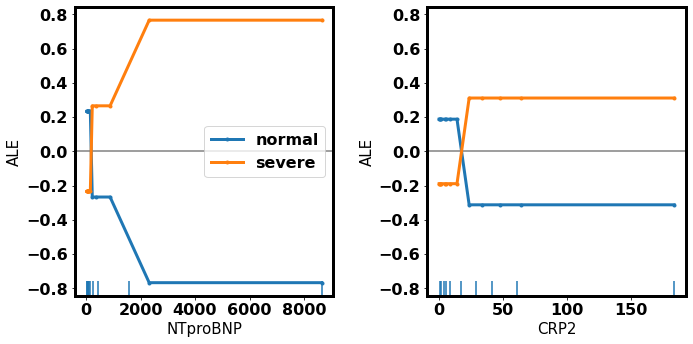

In [572]:
parameters = {'axes.labelsize': 15,
          'axes.titlesize': 20}
plt.rcParams.update(parameters)
plt.rcParams.update({'font.size': 14})
ale_plot(dt, X_train.columns, ['normal', 'severe'], X_train, [8, 13])

**Random Forests**

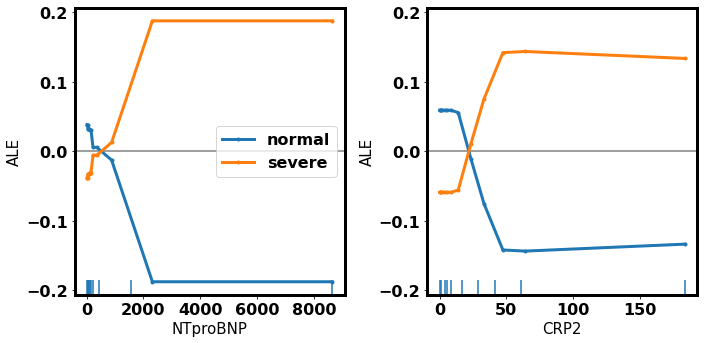

In [573]:
parameters = {'axes.labelsize': 15,
          'axes.titlesize': 20}
plt.rcParams.update(parameters)
plt.rcParams.update({'font.size': 14})

ale_plot(rf, X_train.columns, ['normal', 'severe'], X_train, [8, 13])

**Gradient Boosted Trees**

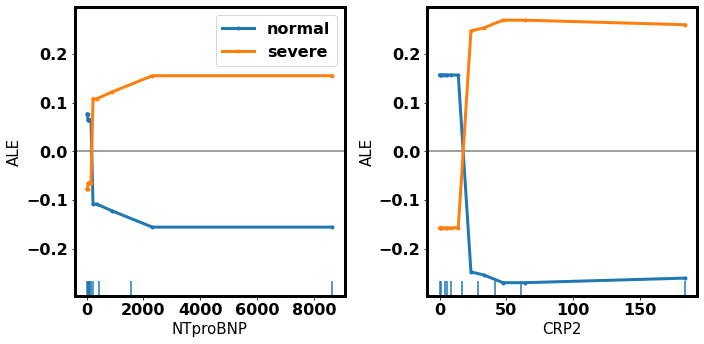

In [576]:
parameters = {'axes.labelsize': 15,
          'axes.titlesize': 20}
plt.rcParams.update(parameters)
plt.rcParams.update({'font.size': 14})

ale_plot_xgbc(xgbc, X_train.columns, ['normal', 'severe'], X_train, [8, 13])

**Neural Networks**

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


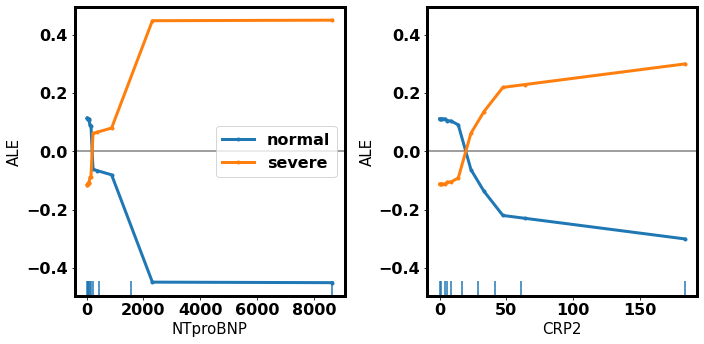

In [577]:
parameters = {'axes.labelsize': 15,
          'axes.titlesize': 20}
plt.rcParams.update(parameters)
plt.rcParams.update({'font.size': 14})

ale_plot(nn, X_train.columns, ['normal', 'severe'], X_train, [8, 13])

### Misclassified Patients

In [356]:
print("dt:\t", dt_pred)
print("rf:\t", rf_pred)
print("xgbc:\t", xgbc_pred)
print("nn:\t", nn_pred.reshape(len(nn_pred)))

print("y_t:\t", y_test)

dt:	 [0 1 1 0 1 0 0 0 0]
rf:	 [0 0 1 0 1 0 0 1 0]
xgbc:	 [0 1 1 0 1 1 1 1 0]
nn:	 [0 1 1 0 1 1 1 1 0]
y_t:	 [0 1 0 0 1 1 0 1 0]


In [357]:
class_names = ['normal', 'severe']

Decision Tree

In [358]:
idx = 2
print("Patient:", idx)
print('Probability(normal) =', dt.predict_proba(np.array(X_test)[idx, :].reshape(1, -1))[0][0])
print('True class: %s' % class_names[y_test[idx]])

Patient: 2
Probability(normal) = 0.0
True class: normal


In [359]:
idx = 5
print("Patient:", idx)
print('Probability(normal) =', dt.predict_proba(np.array(X_test)[idx, :].reshape(1, -1))[0][0])
print('True class: %s' % class_names[y_test[idx]])

Patient: 5
Probability(normal) = 1.0
True class: severe


In [360]:
idx = 7
print("Patient:", idx)
print('Probability(normal) =', dt.predict_proba(np.array(X_test)[idx, :].reshape(1, -1))[0][0])
print('True class: %s' % class_names[y_test[idx]])

Patient: 7
Probability(normal) = 1.0
True class: severe


Random Forest

In [361]:
idx = 2
print("Patient:", idx)
print('Probability(normal) =', rf.predict_proba(np.array(X_test)[idx, :].reshape(1, -1))[0][0])
print('True class: %s' % class_names[y_test[idx]])

Patient: 2
Probability(normal) = 0.47
True class: normal


In [362]:
idx = 5
print("Patient:", idx)
print('Probability(normal) =', rf.predict_proba(np.array(X_test)[idx, :].reshape(1, -1))[0][0])
print('True class: %s' % class_names[y_test[idx]])

Patient: 5
Probability(normal) = 0.76
True class: severe


In [363]:
idx = 7
print("Patient:", idx)
print('Probability(normal) =', rf.predict_proba(np.array(X_test)[idx, :].reshape(1, -1))[0][0])
print('True class: %s' % class_names[y_test[idx]])

Patient: 7
Probability(normal) = 0.46
True class: severe


### 7.5 False Negative #5

In [399]:
X_test.iloc[5]

Sex                   1.00
Age                  63.00
AgeG1                 1.00
Temp                 36.40
cTnITimes             7.00
cTnI                  0.01
cTnICKMBOrdinal1      0.00
LDH                 220.00
NTproBNP            433.00
LYM1                  1.53
N2L1                  3.13
CRP1                 22.69
ALB1                 39.20
CRP2                 22.69
ALB2                 36.50
Sympton               0.00
Fever                 0.00
Cough                 0.00
Phlegm                0.00
Hemoptysis            0.00
SoreThroat            0.00
Catarrh               0.00
Headache              0.00
ChestPain             0.00
Fatigue               0.00
SoreMuscle            0.00
Diarrhea              0.00
PoorAppetite          0.00
NauseaNVomit          0.00
Hypertention          1.00
Hyperlipedia          0.00
DM                    0.00
Lung                  0.00
CAD                   0.00
Cancer                0.00
NSympton              0.00
NDisease              1.00
N

In [351]:
from lime import lime_tabular
import pandas as pd

In [352]:
import shap
shap.initjs()
from alibi.explainers import KernelShap

In [353]:
idx = 5

In [354]:
X_train.columns

Index(['Sex', 'Age', 'AgeG1', 'Temp', 'cTnITimes', 'cTnI', 'cTnICKMBOrdinal1',
       'LDH', 'NTproBNP', 'LYM1', 'N2L1', 'CRP1', 'ALB1', 'CRP2', 'ALB2',
       'Sympton', 'Fever', 'Cough', 'Phlegm', 'Hemoptysis', 'SoreThroat',
       'Catarrh', 'Headache', 'ChestPain', 'Fatigue', 'SoreMuscle', 'Diarrhea',
       'PoorAppetite', 'NauseaNVomit', 'Hypertention', 'Hyperlipedia', 'DM',
       'Lung', 'CAD', 'Cancer', 'NSympton', 'NDisease'],
      dtype='object')

In [355]:
categorical_features = [0, 2, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
categorical_names = {}
for c in categorical_features:
    categorical_names[c] = ["False", "True"]

**Decision Tree**

Patient id: 5
Probability(normal) = 1.0
True class: severe


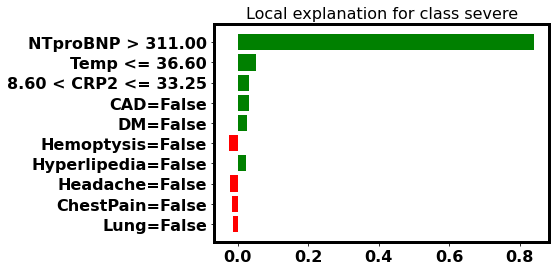

In [703]:
idx = 5
class_names = ['normal', 'severe']

print('Patient id: %d' % idx)
print('Probability(normal) =', dt.predict_proba(np.array(X_test)[idx, :].reshape(1, -1))[0][0])
print('True class: %s' % class_names[y_test[idx]])

explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                              feature_names= X_train.columns, class_names = class_names, 
                                              categorical_features = categorical_features, categorical_names = categorical_names,
                                              discretize_continuous=True)
exp = explainer.explain_instance(np.array(X_test)[idx, :], predict_fn = dt.predict_proba, num_features = 10)

%matplotlib inline
fig = exp.as_pyplot_figure()

In [704]:
explainer = KernelShap(dt.predict_proba)
explainer.fit(X_train)

KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'identity',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': False,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            }
)

In [705]:
dt.predict_proba(X_test)[idx]

array([1., 0.])

In [706]:
explanation = explainer.explain(X_test.to_numpy()[idx].reshape(1, -1))
shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [707]:
shap.save_html('dt_5.html', shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
))

**Random Forest**

Patient id: 5
Probability(normal) = 0.76
True class: severe


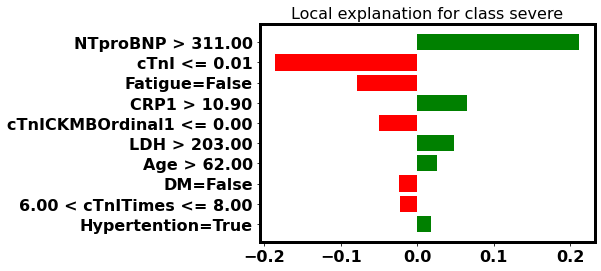

In [696]:
idx = 5
class_names = ['normal', 'severe']

print('Patient id: %d' % idx)
print('Probability(normal) =', rf.predict_proba(np.array(X_test)[idx, :].reshape(1, -1))[0][0])
print('True class: %s' % class_names[y_test[idx]])
explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                              feature_names= X_train.columns, class_names = class_names, 
                                              categorical_features = categorical_features, categorical_names = categorical_names,
                                              discretize_continuous=True)
exp = explainer.explain_instance(np.array(X_test)[idx, :], predict_fn = rf.predict_proba, num_features = 10)

%matplotlib inline
fig = exp.as_pyplot_figure()

In [697]:
# exp.show_in_notebook(show_table=True, show_all=False)

In [698]:
# exp.as_list()

In [699]:
explainer = KernelShap(rf.predict_proba)
explainer.fit(X_train)

KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'identity',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': False,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            }
)

In [700]:
rf.predict_proba(X_test)[idx]

array([0.76, 0.24])

In [701]:
explanation = explainer.explain(X_test.to_numpy()[idx].reshape(1, -1))
shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [702]:
shap.save_html('rf_5.html', shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
))

**Gradient Boosted Trees**

In [617]:
def predict_fn_xbg(X):
    X_data = pd.DataFrame(data=X, columns=xgbc.get_booster().feature_names)
    return xgbc.predict_proba(X_data)

Patient id: 5
Probability(normal) = 0.24060446
True class: severe


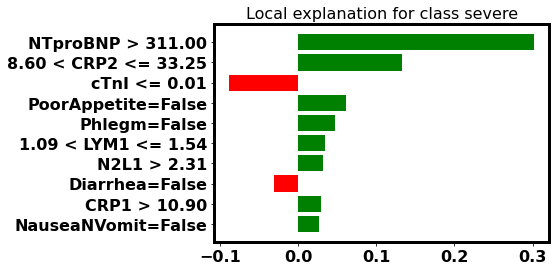

In [690]:
idx = 5
print('Patient id: %d' % idx)
print('Probability(normal) =', xgbc.predict_proba(X_test[idx:idx+1])[0][0])
print('True class: %s' % class_names[y_test[idx]])
explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                              feature_names= X_train.columns, class_names = ['normal', 'severe'], 
                                              categorical_features = categorical_features, categorical_names = categorical_names,
                                              discretize_continuous=True)
exp = explainer.explain_instance(np.array(X_test)[idx, :], predict_fn = predict_fn_xbg, num_features = 10)

%matplotlib inline
fig = exp.as_pyplot_figure()

In [691]:
def predict_fn_xbg(X):
    X_data = pd.DataFrame(data=X, columns=xgbc.get_booster().feature_names)
    return xgbc.predict(X_data)

In [692]:
explainer = KernelShap(xgbc.predict_proba)
explainer.fit(X_train)

KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'identity',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': False,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            }
)

In [693]:
xgbc.predict_proba(X_test)[idx]

array([0.24060446, 0.75939554], dtype=float32)

In [694]:
explanation = explainer.explain(X_test.to_numpy()[idx].reshape(1, -1))
shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [695]:
shap.save_html('xgbc_5.html', shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
))

**Neural Networks**

In [623]:
def predict_fn_nn(X):
    pred = nn.predict(X)
    return np.concatenate((1-pred, pred),axis=1)

Patient id: 5
Probability(normal) = 0
True class: severe


`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


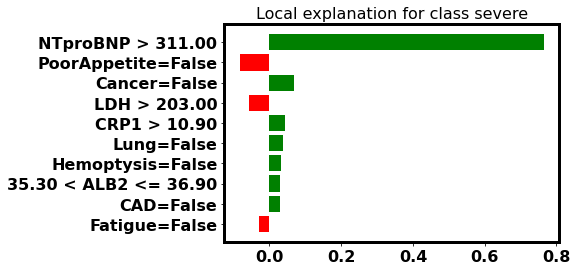

In [689]:
idx = 5
class_names = ['normal', 'severe']

print('Patient id: %d' % idx)
print('Probability(normal) =', 1 - nn.predict(np.array(X_test)[idx, :].reshape(1, -1))[0][0])
print('True class: %s' % class_names[y_test[idx]])
explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                              feature_names= X_train.columns, class_names = class_names, 
                                              categorical_features = categorical_features, categorical_names = categorical_names,
                                              discretize_continuous=True)
exp = explainer.explain_instance(np.array(X_test)[idx, :], predict_fn = predict_fn_nn, num_features = 10)
%matplotlib inline
fig = exp.as_pyplot_figure()

In [684]:
explainer = KernelShap(nn.predict_proba)
explainer.fit(X_train)

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'identity',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': False,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            }
)

In [685]:
nn.predict_proba(X_test)[idx]

array([0.40912193, 0.59087807], dtype=float32)

In [686]:
explanation = explainer.explain(X_test.to_numpy()[idx].reshape(1, -1))
shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
)

  0%|          | 0/1 [00:00<?, ?it/s]

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


In [688]:
shap.save_html('nn_5.html', shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
))

### 7.6 False Positive #2

In [398]:
X_test.iloc[2]

Sex                   1.00
Age                  42.00
AgeG1                 0.00
Temp                 37.50
cTnITimes             8.00
cTnI                  0.01
cTnICKMBOrdinal1      0.00
LDH                 263.00
NTproBNP            475.00
LYM1                  1.08
N2L1                  2.16
CRP1                 36.49
ALB1                 37.60
CRP2                 78.76
ALB2                 37.60
Sympton               1.00
Fever                 1.00
Cough                 0.00
Phlegm                0.00
Hemoptysis            0.00
SoreThroat            0.00
Catarrh               0.00
Headache              0.00
ChestPain             0.00
Fatigue               0.00
SoreMuscle            0.00
Diarrhea              0.00
PoorAppetite          0.00
NauseaNVomit          0.00
Hypertention          1.00
Hyperlipedia          1.00
DM                    1.00
Lung                  0.00
CAD                   0.00
Cancer                0.00
NSympton              1.00
NDisease              3.00
N

**Decision Tree**

Patient id: 2
Probability(normal) = 0.0
True class: normal


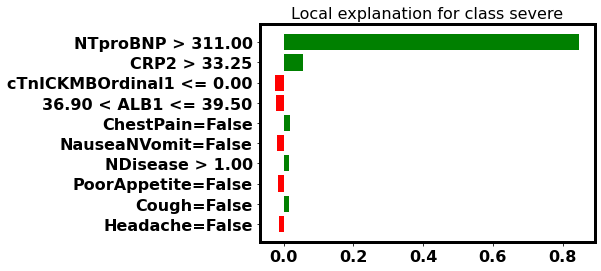

In [657]:
idx = 2
class_names = ['normal', 'severe']

print('Patient id: %d' % idx)
print('Probability(normal) =', dt.predict_proba(np.array(X_test)[idx, :].reshape(1, -1))[0][0])
print('True class: %s' % class_names[y_test[idx]])

explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                              feature_names= X_train.columns, class_names = class_names, 
                                              categorical_features = categorical_features, categorical_names = categorical_names,
                                              discretize_continuous=True)
exp = explainer.explain_instance(np.array(X_test)[idx, :], predict_fn = dt.predict_proba, num_features = 10)

%matplotlib inline
fig = exp.as_pyplot_figure()

In [663]:
explainer = KernelShap(dt.predict_proba)
explainer.fit(X_train)

KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'identity',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': False,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            }
)

In [664]:
dt.predict_proba(X_test)[idx]

array([0., 1.])

In [665]:
explanation = explainer.explain(X_test.to_numpy()[idx].reshape(1, -1))
shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [666]:
shap.save_html('dt_2.html', shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
))

**Random Forest**

Patient id: 2
Probability(normal) = 0.47
True class: normal


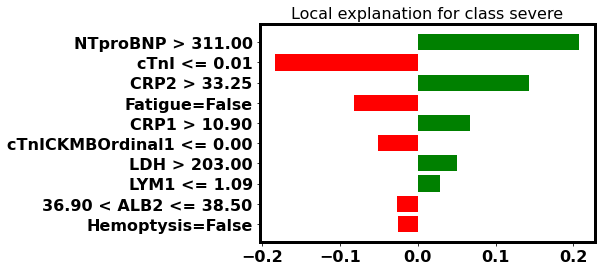

In [653]:
idx = 2
class_names = ['normal', 'severe']

print('Patient id: %d' % idx)
print('Probability(normal) =', rf.predict_proba(np.array(X_test)[idx, :].reshape(1, -1))[0][0])
print('True class: %s' % class_names[y_test[idx]])
explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                              feature_names= X_train.columns, class_names = class_names, 
                                              categorical_features = categorical_features, categorical_names = categorical_names,
                                              discretize_continuous=True)
exp = explainer.explain_instance(np.array(X_test)[idx, :], predict_fn = rf.predict_proba, num_features = 10)

%matplotlib inline
fig = exp.as_pyplot_figure()

In [379]:
# exp.show_in_notebook(show_table=True, show_all=False)

In [380]:
# exp.as_list()

In [667]:
explainer = KernelShap(rf.predict_proba)
explainer.fit(X_train)

KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'identity',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': False,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            }
)

In [668]:
rf.predict_proba(X_test)[idx]

array([0.47, 0.53])

In [669]:
explanation = explainer.explain(X_test.to_numpy()[idx].reshape(1, -1))
shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [670]:
shap.save_html('rf_2.html', shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
))

**Gradient Boosted Trees**

In [655]:
def predict_fn_xbg(X):
    X_data = pd.DataFrame(data=X, columns=xgbc.get_booster().feature_names)
    return xgbc.predict_proba(X_data)

Patient id: 2
Probability(normal) = 0.10256773
True class: normal


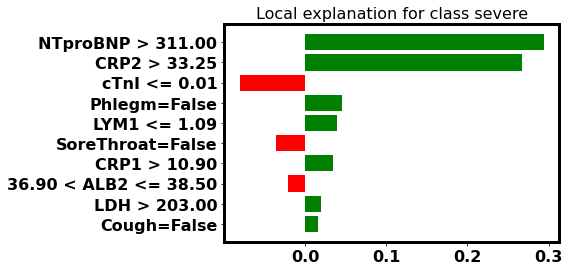

In [656]:
idx = 2
print('Patient id: %d' % idx)
print('Probability(normal) =', xgbc.predict_proba(X_test[idx:idx+1])[0][0])
print('True class: %s' % class_names[y_test[idx]])
explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                              feature_names= X_train.columns, class_names = ['normal', 'severe'], 
                                              categorical_features = categorical_features, categorical_names = categorical_names,
                                              discretize_continuous=True)
exp = explainer.explain_instance(np.array(X_test)[idx, :], predict_fn = predict_fn_xbg, num_features = 10)

%matplotlib inline
fig = exp.as_pyplot_figure()

In [671]:
explainer = KernelShap(xgbc.predict_proba)
explainer.fit(X_train)

KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'identity',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': False,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            }
)

In [672]:
xgbc.predict_proba(X_test)[idx]

array([0.10256773, 0.89743227], dtype=float32)

In [673]:
explanation = explainer.explain(X_test.to_numpy()[idx].reshape(1, -1))
shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [674]:
shap.save_html('xgbc_2.html', shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
))

**Neural Networks**

In [661]:
def predict_fn_nn(X):
    pred = nn.predict(X)
    return np.concatenate((1-pred, pred),axis=1)

Patient id: 2
Probability(normal) = 0
True class: normal


`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


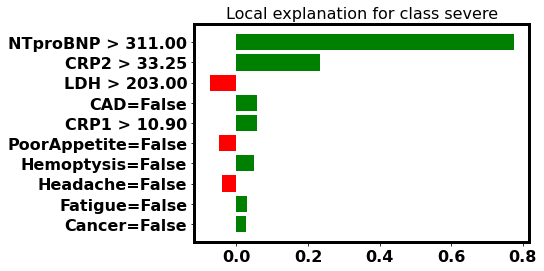

In [662]:
idx = 2
class_names = ['normal', 'severe']

print('Patient id: %d' % idx)
print('Probability(normal) =', 1 - nn.predict(np.array(X_test)[idx, :].reshape(1, -1))[0][0])
print('True class: %s' % class_names[y_test[idx]])
explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                              feature_names= X_train.columns, class_names = class_names, 
                                              categorical_features = categorical_features, categorical_names = categorical_names,
                                              discretize_continuous=True)
exp = explainer.explain_instance(np.array(X_test)[idx, :], predict_fn = predict_fn_nn, num_features = 10)
%matplotlib inline
fig = exp.as_pyplot_figure()

In [675]:
explainer = KernelShap(nn.predict_proba)
explainer.fit(X_train)

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'identity',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': False,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            }
)

In [676]:
nn.predict_proba(X_test)[idx]

array([0.37951684, 0.62048316], dtype=float32)

In [677]:
explanation = explainer.explain(X_test.to_numpy()[idx].reshape(1, -1))
shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
#     matplotlib=True
)

  0%|          | 0/1 [00:00<?, ?it/s]

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


In [678]:
shap.save_html('nn_2.html', shap.force_plot(
    explanation.expected_value[1],
    explanation.shap_values[1][0, :] ,
    X_test.to_numpy()[idx].reshape(1, -1),
    X_train.columns,
#     matplotlib=True
))

In [394]:
# explanation.shap_values[0]

## Metrics

In [401]:
from aix360.metrics import faithfulness_metric, monotonicity_metric

In [402]:
x = X_test.iloc[0, :]
base = np.zeros(x.shape[0])

**Decision Tree**

Lime

Decision Tree predicts with either 0 or 1 which introduces divide by zero error

In [403]:
explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                              feature_names= X_train.columns, class_names = class_names, 
                                              categorical_features = categorical_features, categorical_names = categorical_names,
                                              discretize_continuous=True)
ncases = X_test.shape[0]

fait = np.zeros(ncases)
mon = np.zeros(ncases)

for i in range(0, ncases):
    predicted_class = dt.predict(X_test)[i]

    exp = explainer.explain_instance(np.array(X_test)[i, :], dt.predict_proba, num_features=10, top_labels=1)
    le = exp.local_exp[predicted_class]

    x = X_test.iloc[i]
    coefs = np.zeros(x.shape[0])
    
    for v in le:
        coefs[v[0]] = v[1]
    fait[i] = faithfulness_metric(dt, np.array(X_test)[i, :], coefs, base)
    mon[i] = monotonicity_metric(dt, np.array(X_test)[i, :], coefs, base)

print("Faithfulness metric mean: ",np.mean(fait))
print(np.mean(mon), "% of test records where explanation is monotonic")

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


Faithfulness metric mean:  nan
0.8888888888888888 % of test records where explanation is monotonic


invalid value encountered in true_divide
invalid value encountered in true_divide


**Random Forest**

Interpretable Model

In [574]:
print("Faithfulness: ", faithfulness_metric(rf, x.to_numpy(), rf.feature_importances_, base))
print("Monotonity: ", monotonicity_metric(rf, x.to_numpy(), rf.feature_importances_, base))

Faithfulness:  0.2064295880874643
Monotonity:  False


Lime

In [575]:
explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                              feature_names= X_train.columns, class_names = class_names, 
                                              categorical_features = categorical_features, categorical_names = categorical_names,
                                              discretize_continuous=True)
ncases = X_test.shape[0]

fait = np.zeros(ncases)
mon = np.zeros(ncases)

for i in range(0, ncases):
    predicted_class = rf.predict(X_test)[i]

    exp = explainer.explain_instance(np.array(X_test)[i, :], rf.predict_proba, num_features=10, top_labels=1)
    le = exp.local_exp[predicted_class]

    x = X_test.iloc[i]
    coefs = np.zeros(x.shape[0])
    
    for v in le:
        coefs[v[0]] = v[1]
    fait[i] = faithfulness_metric(rf, np.array(X_test)[i, :], coefs, base)
    mon[i] = monotonicity_metric(rf, np.array(X_test)[i, :], coefs, base)

print("Faithfulness metric mean: ",np.mean(fait))
print(np.mean(mon), "% of test records where explanation is monotonic")

Faithfulness metric mean:  0.3706447258375962
0.0 % of test records where explanation is monotonic


Shape

In [576]:
explainer = KernelShap(rf.predict_proba, feature_names=list(X_test.columns))
explainer.fit(X_train)
ncases = X_test.shape[0]
fait = np.zeros(ncases)
mon = np.zeros(ncases)
for i in range(0, ncases):
    explanation = explainer.explain(X_test.to_numpy()[i].reshape(1, -1))
    fait[i] = faithfulness_metric(rf, np.array(X_test)[i, :], explanation.shap_values[rf_pred[i]][0], base)
    mon[i] = monotonicity_metric(rf, np.array(X_test)[i, :], explanation.shap_values[rf_pred[i]][0], base)

print("Faithfulness metric mean: ", np.mean(fait))
print(np.mean(mon), "% of test records where explanation is monotonic")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Faithfulness metric mean:  0.5939099845049222
0.0 % of test records where explanation is monotonic


**XGBC**

lime

In [585]:
explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                              feature_names= X_train.columns, class_names = ['normal', 'severe'], 
                                              categorical_features = categorical_features, categorical_names = categorical_names,
                                              discretize_continuous=True)
ncases = X_test.shape[0]

fait = np.zeros(ncases)
mon = np.zeros(ncases)

for i in range(0, ncases):
    predicted_class = xgbc_pred[i]

    exp = explainer.explain_instance(np.array(X_test)[idx, :], xgbc.predict_proba, num_features = 10, top_labels=1)
    le = exp.local_exp[1]

    x = X_test.iloc[i]
    coefs = np.zeros(x.shape[0])

    for v in le:
        coefs[v[0]] = v[1]

    fait[i] = faithfulness_metric(xgbc, np.array(X_test)[i, :], coefs, base)
    mon[i] = monotonicity_metric(xgbc, np.array(X_test)[i, :], coefs, base)

print("Faithfulness metric mean: ",np.mean(fait))
print(int(np.mean(mon)*100), "% of test records where explanation is monotonic")

Faithfulness metric mean:  0.4602084517025975
0.2222222222222222 % of test records where explanation is monotonic


SHAP

In [588]:
explainer = KernelShap(xgbc.predict_proba, feature_names=list(X_test.columns))
explainer.fit(X_train)

ncases = X_test.shape[0]

fait = np.zeros(ncases)
mon = np.zeros(ncases)

for i in range(0, ncases):
    explanation = explainer.explain(X_test.to_numpy()[i].reshape(1, -1))
    fait[i] = faithfulness_metric(xgbc, np.array(X_test)[i, :], explanation.shap_values[nn_pred[i][0]], base)
    mon[i] = monotonicity_metric(xgbc, np.array(X_test)[i, :], explanation.shap_values[nn_pred[i][0]], base)

print("Faithfulness metric mean: ", np.mean(fait))
print(int(np.mean(mon)*100), "% of test records where explanation is monotonic")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Faithfulness metric mean:  0.4866643621494886
22 % of test records where explanation is monotonic


**Neural Networks**

lime

In [586]:
explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                              feature_names= X_train.columns, class_names = class_names, 
                                              categorical_features = categorical_features, categorical_names = categorical_names,
                                              discretize_continuous=True)
ncases = X_test.shape[0]

fait = np.zeros(ncases)
mon = np.zeros(ncases)

for i in range(0, ncases):
    predicted_class = nn.predict(X_test)[i][0]

    exp = explainer.explain_instance(np.array(X_test)[i, :], nn.predict_proba, num_features=10, top_labels=1)
    le = exp.local_exp[predicted_class]

    x = X_test.iloc[i]
    coefs = np.zeros(x.shape[0])

    for v in le:
        coefs[v[0]] = v[1]

    fait[i] = faithfulness_metric(nn, np.array(X_test)[i, :], coefs, base)
    mon[i] = monotonicity_metric(nn, np.array(X_test)[i, :], coefs, base)

print("Faithfulness metric mean: ",np.mean(fait))
print(np.mean(mon), "% of test records where explanation is monotonic")

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`m

Faithfulness metric mean:  0.4507578355426194
0.0 % of test records where explanation is monotonic


Shap

In [587]:
explainer = KernelShap(rf.predict_proba, feature_names=list(X_test.columns))
explainer.fit(X_train)

ncases = X_test.shape[0]

fait = np.zeros(ncases)
mon = np.zeros(ncases)

for i in range(0, ncases):
    explanation = explainer.explain(X_test.to_numpy()[i].reshape(1, -1))
    fait[i] = faithfulness_metric(nn, np.array(X_test)[i, :], explanation.shap_values[nn_pred[i][0]], base)
    mon[i] = monotonicity_metric(nn, np.array(X_test)[i, :], explanation.shap_values[nn_pred[i][0]], base)

print("Faithfulness metric mean: ", np.mean(fait))
print(int(np.mean(mon)*100), "% of test records where explanation is monotonic")

  0%|          | 0/1 [00:00<?, ?it/s]

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


  0%|          | 0/1 [00:00<?, ?it/s]

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


  0%|          | 0/1 [00:00<?, ?it/s]

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


  0%|          | 0/1 [00:00<?, ?it/s]

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


  0%|          | 0/1 [00:00<?, ?it/s]

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


  0%|          | 0/1 [00:00<?, ?it/s]

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


  0%|          | 0/1 [00:00<?, ?it/s]

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


  0%|          | 0/1 [00:00<?, ?it/s]

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


  0%|          | 0/1 [00:00<?, ?it/s]

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


Faithfulness metric mean:  0.33058518194205555
0.0 % of test records where explanation is monotonic
